# Visualize the dataset named 'household_power_consumption'

In [1]:
%matplotlib inline
import copy 
from os.path import join
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import mpld3

import utils.opfiles as opfile
import settings.parameters as para
import utils.auxiliary as auxi

mpld3.enable_notebook()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
path_data = join(para.WORK_DIRECTORY, "data", "input", "household_power_consumption.txt")
data = opfile.read_txt(path_data)
data = [d.split(';') for d in data][1:]

In [3]:
def str2time(data):
    pattern = '%d/%m/%Y %H:%M:%S'
    return [[auxi.str2time(d[0] + ' ' + d[1], pattern), ] + d[2:] for d in data]
newdata = str2time(data)

# Data Preprocessing

In [4]:
def check_missing(data, index):
    missing = [d for d in data if d[index] == '?']
    num_missing = len(missing)
    return missing, num_missing
missing, num_missing = check_missing(newdata, 1)

In [5]:
def rebuild_data(line):
    return [line[0]] + map(float, line[1:])

def remove_missing(data, index):
    return [rebuild_data(line) for line in data if line[index] != '?']
valid_data = remove_missing(newdata, index=1)

# Visualize the data in different dimension.

In [6]:
def plot_timeseries(times, values):
    # define data format.
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    monthFmt = mdates.DateFormatter('%M')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(times, values)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthFmt)
    ax.xaxis.set_minor_locator(months)
    ax.set_xlim(times[0], times[-1])
    ax.set_ylim(min(values), max(values))
    plt.tight_layout()
    plt.show()

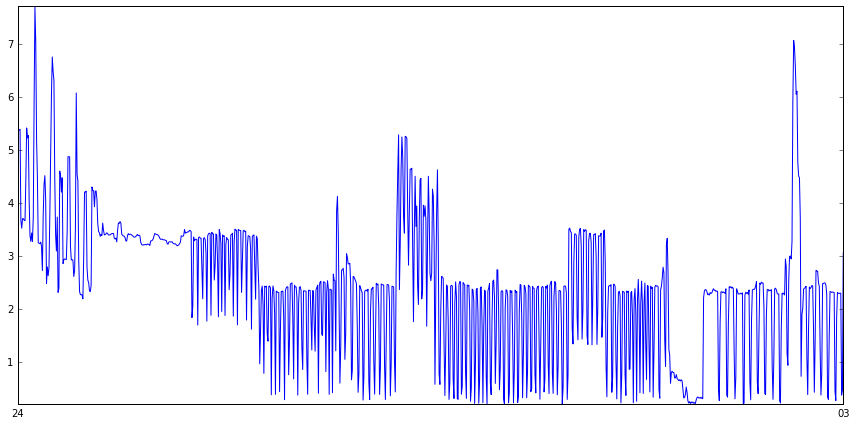

In [7]:
sub_data = valid_data[: 1000]
times = map(lambda x: x[0], sub_data)
values = map(lambda x: x[1], sub_data)
plot_timeseries(times, values)

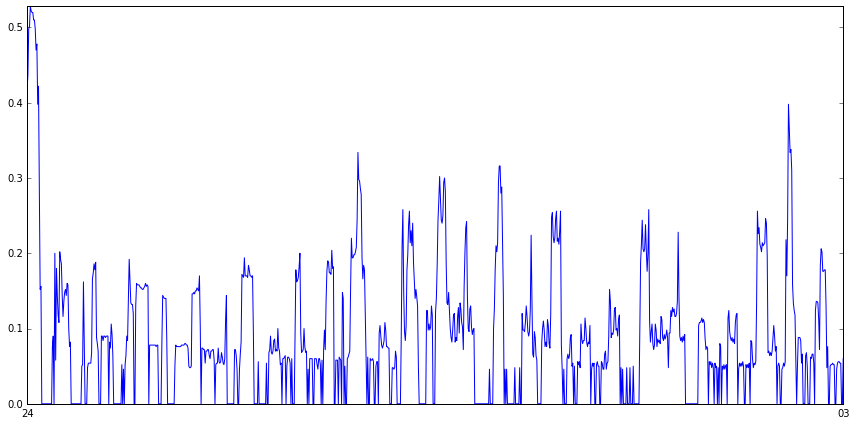

In [8]:
sub_data = valid_data[: 1000]
times = map(lambda x: x[0], sub_data)
values = map(lambda x: x[2], sub_data)
plot_timeseries(times, values)

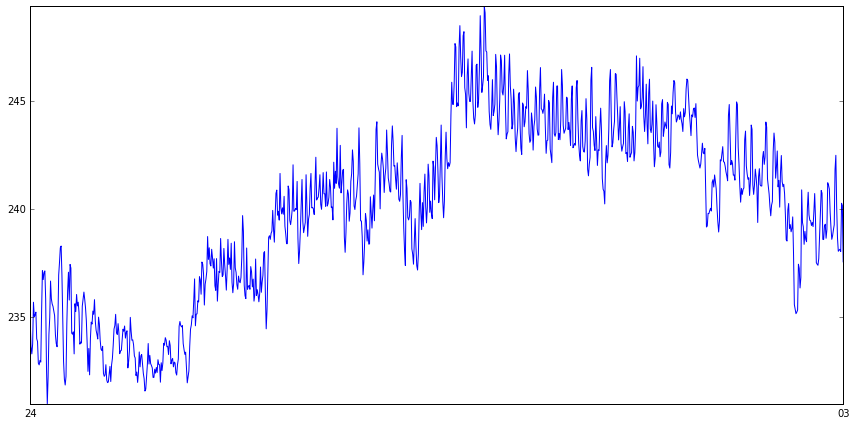

In [9]:
sub_data = valid_data[: 1000]
times = map(lambda x: x[0], sub_data)
values = map(lambda x: x[3], sub_data)
plot_timeseries(times, values)

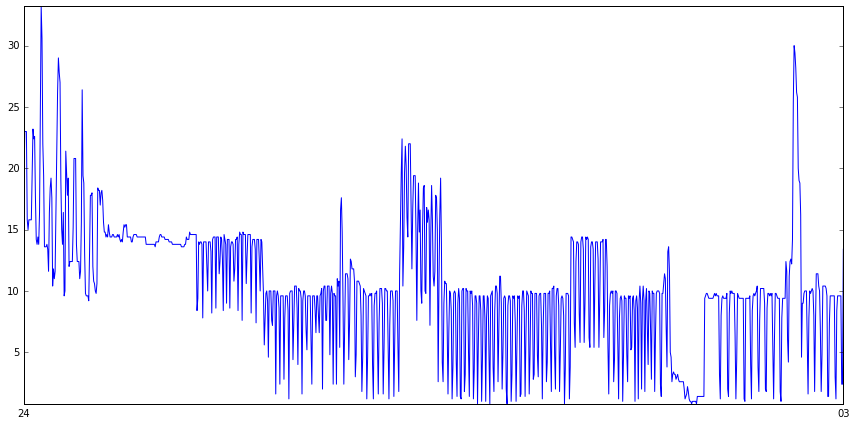

In [10]:
sub_data = valid_data[: 1000]
times = map(lambda x: x[0], sub_data)
values = map(lambda x: x[4], sub_data)
plot_timeseries(times, values)

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


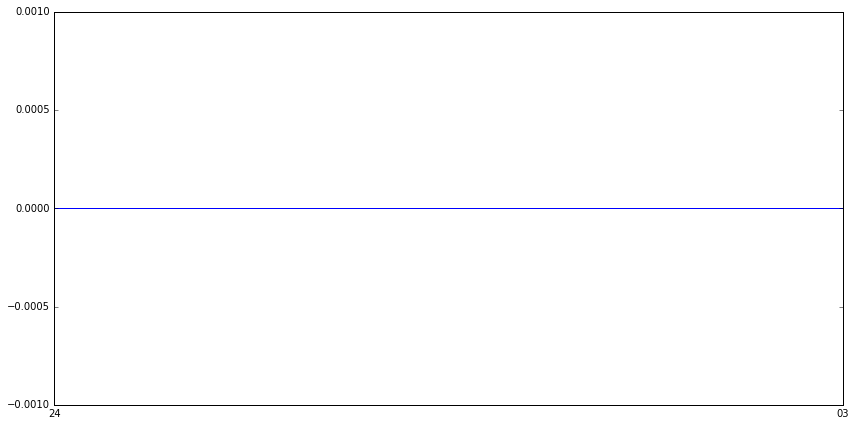

In [11]:
sub_data = valid_data[: 1000]
times = map(lambda x: x[0], sub_data)
values = map(lambda x: x[5], sub_data)
plot_timeseries(times, values)

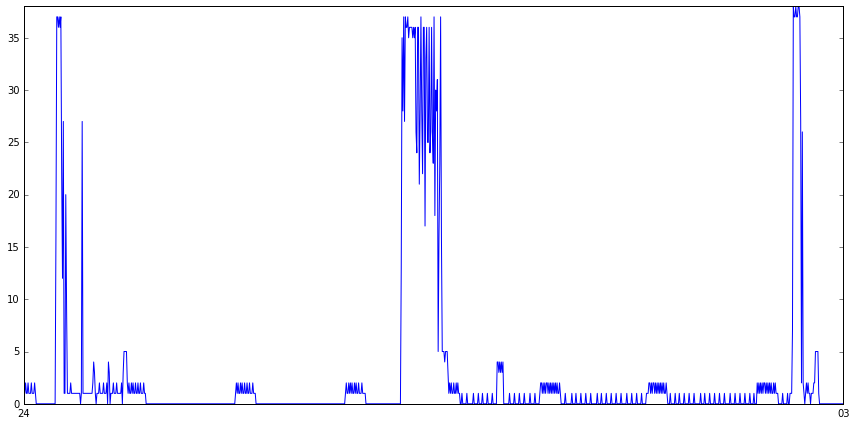

In [12]:
sub_data = valid_data[: 1000]
times = map(lambda x: x[0], sub_data)
values = map(lambda x: x[6], sub_data)
plot_timeseries(times, values)

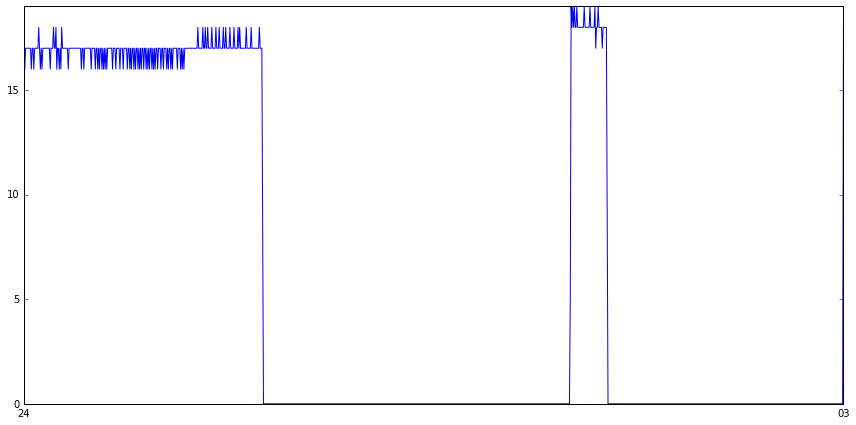

In [13]:
sub_data = valid_data[: 1000]
times = map(lambda x: x[0], sub_data)
values = map(lambda x: x[7], sub_data)
plot_timeseries(times, values)

# Data processing

In [14]:
def check_time_interval(data):
    """check if the interval of the time series is equivalent."""
    times = map(lambda x: x[0], data)
    times1 = times[: -1]
    times2 = times[1:]
    times_zip = zip(times1, times2)
    times_intervals = map(lambda x: x[1] - x[0], times_zip)
    minimal_time_interval = min(times_intervals)
    return minimal_time_interval, times_intervals, all([t == minimal_time_interval for t in times_intervals])

In [15]:
minimal_interval, intervals, equal_intervals = check_time_interval(valid_data)

In [16]:
def split_imbalance_intervals(minimal_interval, intervals, data):
    """split the imbalance intervals to balance intervals.

    More precisely, cut off the original intervals.
    """
    splited_points = [
        (ind, interval) for ind, interval in enumerate(intervals)
        if interval != minimal_interval]
    interval_index = [-1] + [point[0] for point in splited_points]
    interval_index_zip = zip(interval_index[:-1], interval_index[1:])
    return [data[start + 1: end] for start, end in interval_index_zip]
balanced_data = split_imbalance_intervals(minimal_interval, intervals, valid_data)

In [17]:
good_serie = map(lambda x: (x[0], x[3]), valid_data)

def num_of_missing_record(interval, minimal_interval):
    return int(interval.total_seconds() / minimal_interval.total_seconds())

def fillin_missing_records(minimal_interval, intervals, data):
    gaps = [
        ind for ind, interval in enumerate(intervals)
        if interval != minimal_interval]

    newdata = []
    for index, gap in enumerate(gaps):  
        start = data[gap]
        end = data[gap + 1]
        interval = end[0] - start[0]
        num_of_missing = num_of_missing_record(end[0] - start[0], minimal_interval)
        scale_of_missing = end[1] - start[1]
        slope = scale_of_missing / num_of_missing
        insert_points = [(start[0] + minimal_interval * ind, start[1] + slope * ind)
                         for ind in xrange(1, num_of_missing)]
        
        if index == 0:
            newdata += data[: gaps[index] + 1]
        else:
            newdata += data[gaps[index-1] + 1: gaps[index] + 1]
        newdata += insert_points
    newdata += data[gaps[index] + 1:]
    return newdata
    
filled_data = fillin_missing_records(minimal_interval, intervals, good_serie)

In [18]:
def least_square(y, tx):
    """calculate the least square."""
    a = tx.T.dot(tx)
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

def compute_cost(y, tx, beta):
    """compute the cost by rmse."""
    e = y - tx.dot(beta)
    mse = e.dot(e) / (2 * len(e))
    return np.sqrt(mse)

def fit_intervals(y):
    tx = np.c_[np.ones(len(y)).T, np.arange(len(y)).T]
    y = np.array(y).T
    beta = least_square(y, tx)
    rmse = compute_cost(y, tx, beta)
    return beta, rmse
    
def linear_segmentation(serie):
    info = [0]
    points = []
    for ind, point in enumerate(serie):
        if len(points) < 2:
            points.append(point)
            continue
        else:
            tmp_points = copy.copy(points)
            tmp_points.append(point)
            beta, rmse = fit_intervals(tmp_points)
            if rmse > 0.6:
                info.append(info[-1] + len(points) - 1)
                points = tmp_points[-2: ]
            else:
                points.append(point)
            break
    info.append(len(serie))
    return info
            

info = linear_segmentation(map(lambda x: x[1], filled_data))